# 📓 Notebook - Teori & Praktik Bab 8: Dimensionality Reduction

Banyak masalah Machine Learning melibatkan ribuan atau bahkan jutaan fitur untuk setiap instans data. Ini menyebabkan masalah yang dikenal sebagai **The Curse of Dimensionality**:
1.  Pelatihan menjadi sangat lambat.
2.  Sulit menemukan solusi yang baik (data menjadi jarang/sparse).
3.  Sulit memvisualisasikan data.

Bab ini membahas teknik untuk mengurangi jumlah fitur (dimensi) sambil tetap mempertahankan informasi sebanyak mungkin.

Kita akan membahas:
1.  **PCA (Principal Component Analysis)**
2.  **Memilih Jumlah Dimensi yang Tepat**
3.  **PCA untuk Data Besar (Incremental & Randomized)**
4.  **Kernel PCA** (Untuk data non-linear)
5.  **LLE (Locally Linear Embedding)**
6.  **t-SNE** (Untuk visualisasi)

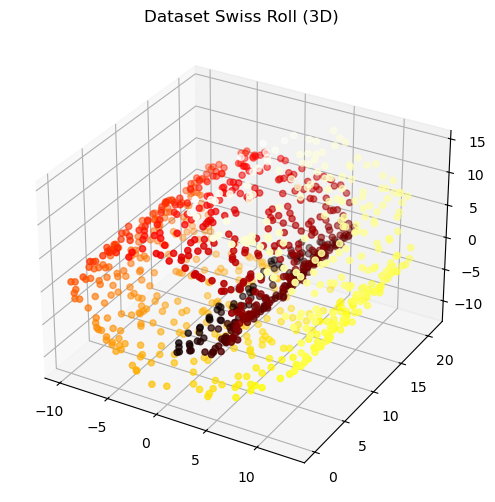

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

# Ini adalah data 3D yang tergulung.
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

# Visualisasi Data 3D 
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.set_title("Dataset Swiss Roll (3D)")
plt.show()

## 1. PCA (Principal Component Analysis)

### Konsep Teori: Proyeksi & Varians
PCA adalah teknik reduksi dimensi yang paling populer. Idenya sederhana: **Proyeksi**.
Bayangkan bayangan sebuah objek 3D di dinding (2D). PCA mencoba mencari sudut dinding terbaik sehingga bayangan objek tersebut tetap terlihat jelas dan tidak "gepeng".

Secara teknis, PCA bekerja dengan:
1.  Mengidentifikasi **Principal Components (PC)**: Sumbu-sumbu di mana data memiliki varians (penyebaran) terbesar.
    * PC1: Sumbu dengan varians terbesar.
    * PC2: Sumbu tegak lurus terhadap PC1 dengan varians terbesar kedua, dst.
2.  Memproyeksikan data ke sumbu-sumbu tersebut.

**SVD (Singular Value Decomposition):** Di balik layar, Scikit-Learn menggunakan teknik aljabar linear bernama SVD untuk mencari komponen ini.

Principal Components (Vektor Arah):
[[ 0.56791312  0.15670748  0.80803308]
 [ 0.77712377  0.2213858  -0.5891239 ]]

Explained Variance Ratio: [0.40782396 0.3020019 ]
Total Informasi yang tersisa: 70.98%


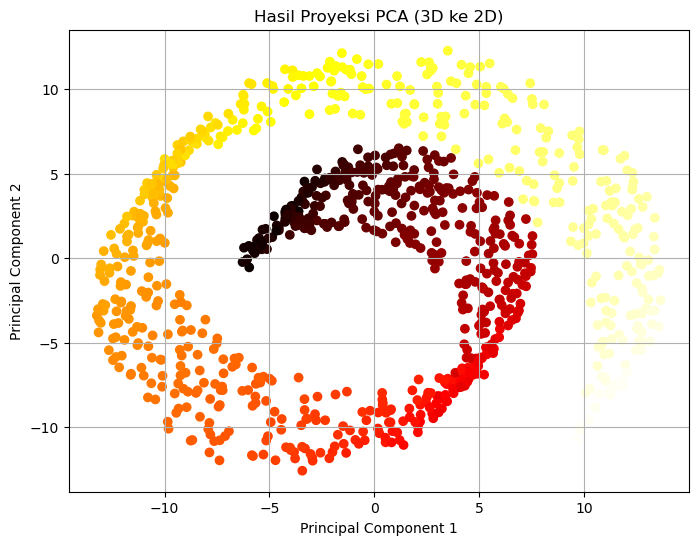

In [ ]:
from sklearn.decomposition import PCA

# Mengurangi data Swiss Roll dari 3D menjadi 2D
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

print("Principal Components (Vektor Arah):")
print(pca.components_)

print("\nExplained Variance Ratio:", pca.explained_variance_ratio_)
print(f"Total Informasi yang tersisa: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

# Plot hasil proyeksi 2D
plt.figure(figsize=(8, 6))
plt.scatter(X2D[:, 0], X2D[:, 1], c=t, cmap=plt.cm.hot)
plt.title("Hasil Proyeksi PCA (3D ke 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# Perhatikan bahwa meskipun sudah menjadi 2D, bentuk gulungan (spiral)
# menjadi 'gepeng' dan bertumpuk. Ini karena PCA adalah proyeksi LINEAR.

## 2. Memilih Jumlah Dimensi yang Tepat

### Konsep Teori
Daripada menebak-nebak berapa jumlah dimensi (`n_components`) yang kita butuhkan (apakah 2? 10? 50?), lebih baik kita menentukan target **preserved variance** (varians yang ingin dipertahankan).

Aturan umum yang baik adalah memilih jumlah dimensi yang menjumlahkan setidaknya **95%** dari varians data asli.

Jumlah dimensi asli: 64
Jumlah dimensi setelah reduksi (95% varians): 29


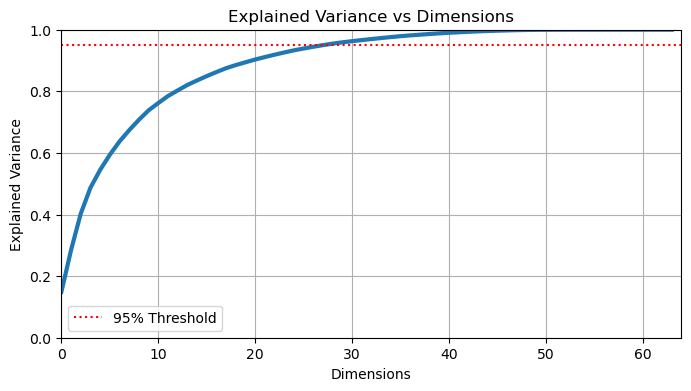

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
X_digits = digits.data

pca_95 = PCA(n_components=0.95)
X_reduced = pca_95.fit_transform(X_digits)

print(f"Jumlah dimensi asli: {X_digits.shape[1]}")
print(f"Jumlah dimensi setelah reduksi (95% varians): {pca_95.n_components_}")

pca = PCA(n_components=64)
pca.fit(X_digits)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 64, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.axhline(y=0.95, color='r', linestyle=':', label="95% Threshold")
plt.grid(True)
plt.legend()
plt.title("Explained Variance vs Dimensions")
plt.show()

## 3. PCA untuk Dataset Besar

### Konsep Teori
PCA standar mengharuskan seluruh dataset dimuat ke dalam memori (RAM). Jika dataset Anda sangat besar, ini tidak mungkin dilakukan.

**Solusi:**
1.  **Incremental PCA (IPCA):** Membagi data menjadi *mini-batches* dan melatih PCA sedikit demi sedikit. Sangat berguna untuk data yang tidak muat di memori.
2.  **Randomized PCA:** Algoritma stokastik yang dengan cepat menemukan perkiraan PC pertama. Jauh lebih cepat daripada PCA biasa jika `n_components` jauh lebih kecil dari dimensi asli.

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 10
inc_pca = IncrementalPCA(n_components=15)

# split data menjadi batch
for X_batch in np.array_split(X_digits, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced_inc = inc_pca.transform(X_digits)
print("Shape hasil Incremental PCA:", X_reduced_inc.shape)

Shape hasil Incremental PCA: (1797, 15)


## 4. Kernel PCA (kPCA)

### Konsep Teori
PCA biasa adalah metode linear. Jika data Anda memiliki struktur non-linear yang kompleks (seperti *Swiss Roll* yang melengkung), PCA biasa akan gagal membuka gulungannya ("unfold").

**Kernel PCA** menggunakan "Kernel Trick" (sama seperti di SVM) untuk secara implisit memetakan data ke dimensi yang sangat tinggi di mana data tersebut mungkin bisa dipisahkan secara linear, lalu memproyeksikannya kembali.

Ini sangat bagus untuk mempertahankan bentuk data yang kompleks.

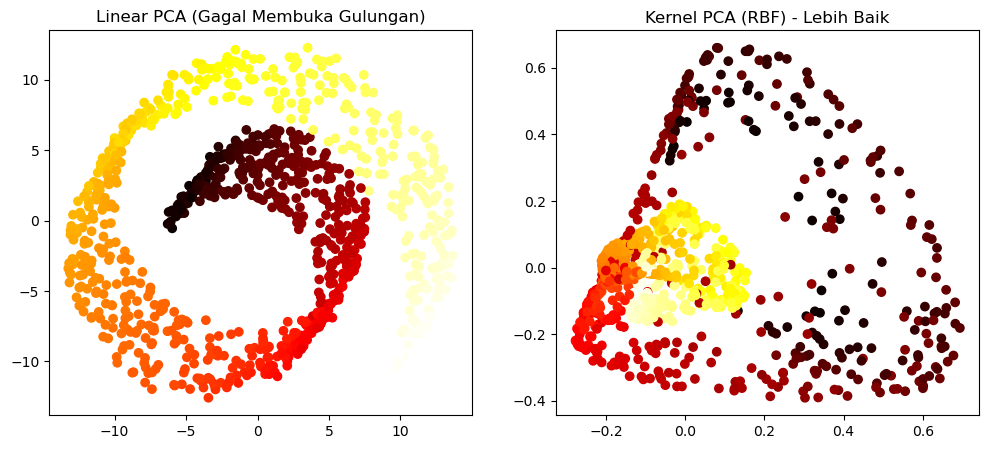

In [ ]:
from sklearn.decomposition import KernelPCA

# Kembali ke dataset Swiss Roll (X, t)
# gunakan kernel RBF (Radial Basis Function)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced_rbf = rbf_pca.fit_transform(X)

# Bandingkan PCA Linear vs Kernel PCA
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

axes[0].scatter(X2D[:, 0], X2D[:, 1], c=t, cmap=plt.cm.hot)
axes[0].set_title("Linear PCA (Gagal Membuka Gulungan)")

axes[1].scatter(X_reduced_rbf[:, 0], X_reduced_rbf[:, 1], c=t, cmap=plt.cm.hot)
axes[1].set_title("Kernel PCA (RBF) - Lebih Baik")

plt.show()

## 5. Locally Linear Embedding

### Konsep Teori
Locally Linear Embedding atau LLE adalah teknik **Manifold Learning**, bukan sekadar proyeksi.

LLE tidak mencoba melestarikan jarak global (seperti PCA), tetapi mencoba melestarikan **jarak lokal**.
1.  Untuk setiap titik data, LLE mencari tetangga terdekatnya.
2.  LLE mencoba merekonstruksi titik tersebut sebagai kombinasi linear dari tetangganya.
3.  LLE mencari representasi dimensi rendah yang menjaga hubungan ketetanggaan ini sebaik mungkin.

Hasilnya sangat bagus untuk membuka gulungan (unrolling) manifold seperti Swiss Roll.

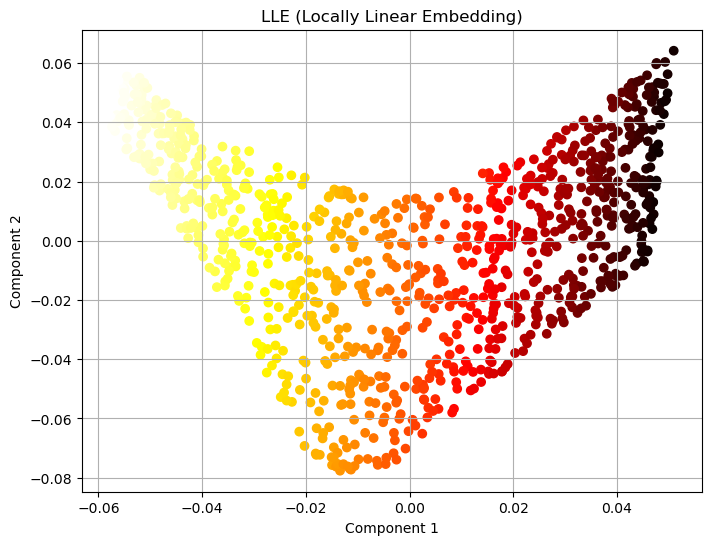

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

# Menggunakan LLE pada Swiss Roll
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced_lle[:, 0], X_reduced_lle[:, 1], c=t, cmap=plt.cm.hot)
plt.title("LLE (Locally Linear Embedding)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

# SeharusnyLLE berhasil 'membuka' gulungan Swiss Roll menjadi 
# pita yang rapi, mempertahankan urutan warna (gradasi) dengan sangat baik.
# Ini adalah sesuatu yang sulit dilakukan oleh PCA.

## 6. t-SNE (t-Distributed Stochastic Neighbor Embedding)

### Konsep Teori
t-SNE adalah teknik yang sangat populer untuk **visualisasi** data berdimensi tinggi.

Prinsip kerjanya:
1.  Mencoba menjaga instance yang mirip agar tetap dekat di dimensi rendah.
2.  Mencoba menjaga instance yang tidak mirip agar saling menjauh.

t-SNE sangat bagus untuk membuat *cluster* visual yang terpisah dengan jelas, tetapi **sangat lambat** untuk dataset besar dan tidak disarankan untuk digunakan dalam pipeline *preprocessing* (hanya untuk visualisasi).

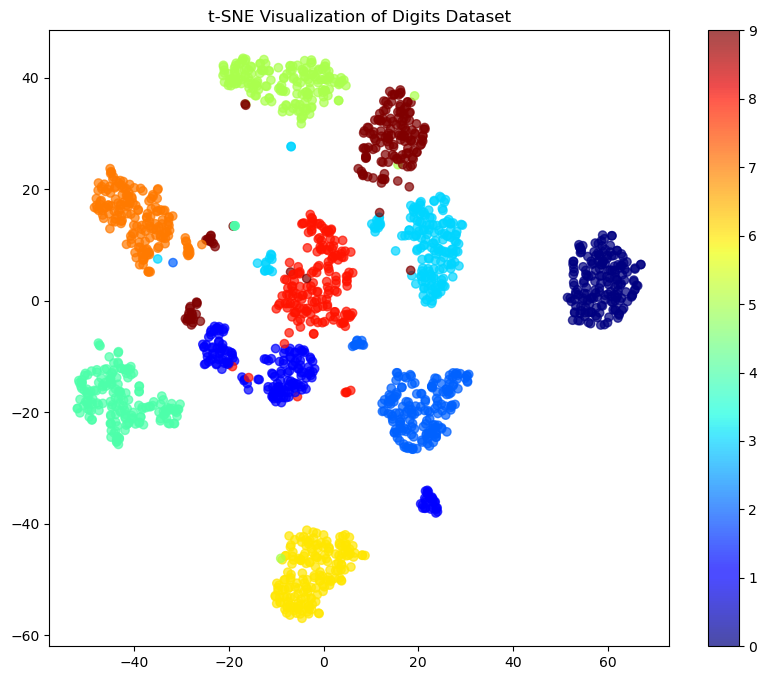

In [ ]:
from sklearn.manifold import TSNE

# Menggunakan dataset Digits lagi karena t-SNE bagus untuk melihat cluster angka
# PENTING: t-SNE lambat, jadi gunakan sebagian data saja atau dataset kecil
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')
X_reduced_tsne = tsne.fit_transform(X_digits)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=digits.target, cmap='jet', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE Visualization of Digits Dataset")
plt.show()

# t-SNE memisahkan angka-angka tulisan tangan (0-9) menjadi kelompok-kelompok 
# yang sangat jelas terpisah, jauh lebih baik daripada PCA.

## Kesimpulan Bab 8

1.  **Reduksi Dimensi** penting untuk mempercepat pelatihan dan memvisualisasikan data.
2.  **PCA** adalah pilihan *default* terbaik untuk proyeksi linear. Gunakan varian **Randomized** atau **Incremental** untuk data besar.
3.  Gunakan **Kernel PCA** atau **LLE** jika data memiliki struktur non-linear yang kompleks (manifold).
4.  Gunakan **t-SNE** khusus untuk visualisasi data, bukan untuk preprocessing model ML.